# ApRES processing step 1: Obtaining interpolated and shifted profiles

In [1]:
# Load libraries
import sys
import sys
import pickle
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:58:05 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:58:05 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:58:05 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


The folder `chirp_processing` details the decisions made regarding the chirps. The decisions made involve the attenuation setting used and the bandwidth used, and are addressed by `A11.ipynb`, `A13.ipynb`, and `A14.ipynb`. In short, the attenuation setting with the largest signal with minimal clipping was used, and the bandwidth was decided upon to preserve as many chirps as possible while discarding any clipped portion of the chirp. 

Using these determined settings, we calculate the profiles for each season and station below (a repeat of `save_files.ipynb`). We also take the mean profile across the season, and find the location of the brightest reflector. We attribute this to the surface reflector. We then subtact this value from the `profile_range` variable such that it accounts for the cables. 


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34937")
client

<Client: 'tcp://127.0.0.1:34937' processes=4 threads=16, memory=125.80 GiB>

In [3]:
# define a function to automate each site

def shift_profile_range(profiles,shift_value):
    profiles_adjust = profiles.where(profiles.profile_range > shift_value, drop = True)
    profiles_adjust['profile_range'] = profiles_adjust.profile_range - shift_value
    return profiles_adjust

def save_adjusted_profiles(ds,start_index, A13S23 = False):
    # calculate profiles
    profile = custom_profile(ds.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=start_index)

    # Adjust profile_range 
    surface_location = float(xa.dB(profile).mean(dim='time').idxmax(dim='profile_range'))
    print(f'Surface is around {surface_location:.2f} m in apparent depth')
    profile = shift_profile_range(profile,surface_location)

    # Interpolate onto regular grid
    if A13S23:
        time_to_interp = pd.date_range(profile.time[0].values, profile.time[-1].values, freq="5min")
    else:
        time_to_interp = pd.date_range(profile.time[0].values, profile.time[-1].values, freq="15min")
    profile = profile.interp(time=time_to_interp,method='linear')
    
    # Display size
    print(f'Profile data size is {profile.nbytes/1e9} Gb')
    
    # Plot a preview 
    fig, ax = plt.subplots(figsize=(9,3))
    xa.dB(profile).plot(x='time')
    ax.invert_yaxis()

    return profile

## A11 Summer 2022

Surface is around 10.94 m in apparent depth
Profile data size is 0.529072416 Gb


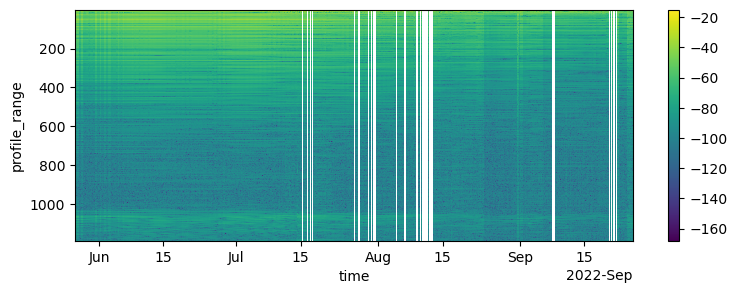

In [4]:
# Load data
ds_11 = reload("A101")
ds_11 = ds_11.isel(time=range(20,len(ds_11.time))) # trim first few bursts, which were tests

profile = save_adjusted_profiles(ds_11,20000)

# Save
with open('A11_22S.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A11 Winter

Surface is around 10.78 m in apparent depth
Profile data size is 2.066137248 Gb


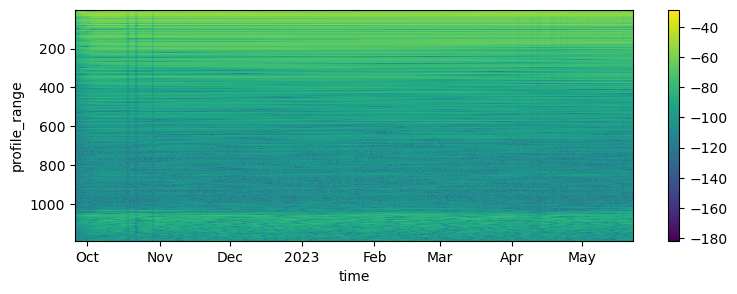

In [5]:
# Load data
ds_11 = reload_winter("A101")

profile = save_adjusted_profiles(ds_11,200)

# Save
with open('A11_22W.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A13 Summer 2022

Surface is around 6.73 m in apparent depth
Profile data size is 0.265472288 Gb


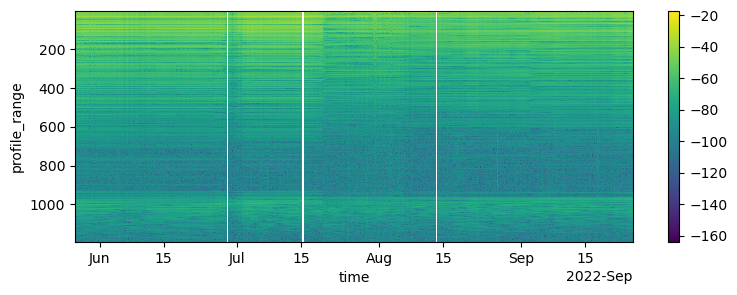

In [6]:
# Load data
ds_13 = reload("A103_fixed")
ds_13 = ds_13.isel(time=range(60,len(ds_13.time))) # trim first few bursts, which were tests

profile = save_adjusted_profiles(ds_13,30000)

# Save
with open('A13_22S.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A13 Winter

Surface is around 6.31 m in apparent depth
Profile data size is 1.64616768 Gb


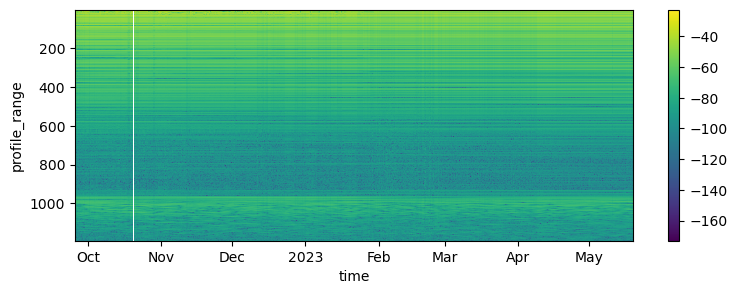

In [7]:
# Load data
ds_13 = reload_winter("A103")

profile = save_adjusted_profiles(ds_13,8000)

# Save
with open('A13_22W.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A13 Summer 2023

Surface is around 6.73 m in apparent depth
Profile data size is 1.360281728 Gb


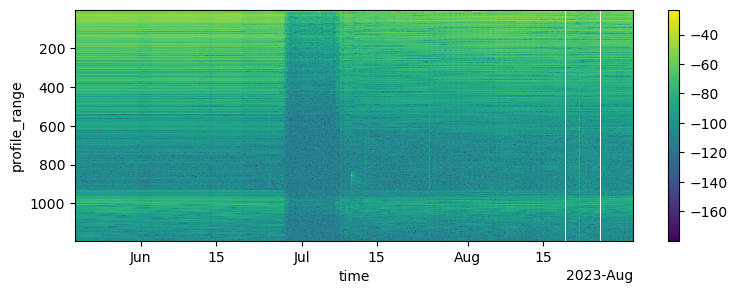

In [8]:
# Load data
ds_13 = reload_summer("A103")
ds_13 = ds_13.isel(time=range(100,len(ds_13.time))) # trim first few bursts, which didn't record properly

profile = save_adjusted_profiles(ds_13,20000,True) # interpolate to 5 minute grid

# Save
with open('A13_23S.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A14 Summer 2022

Surface is around 6.31 m in apparent depth
Profile data size is 0.95540032 Gb


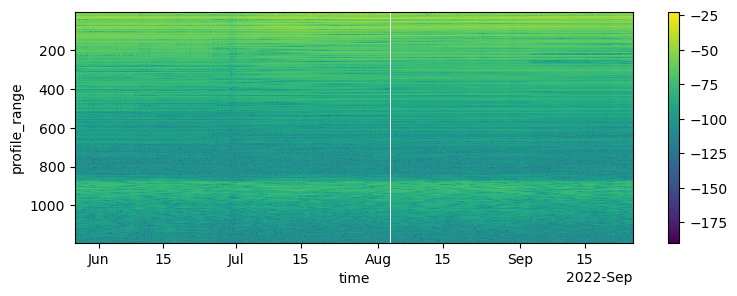

In [9]:
# Load data
ds_14 = reload("A104")
ds_14 = ds_14.isel(time=range(50,len(ds_14.time))) # trim first few bursts, which were tests

profile = save_adjusted_profiles(ds_14,4000)

# Save
with open('A14_22S.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A14 Winter

Surface is around 6.13 m in apparent depth
Profile data size is 1.558667264 Gb


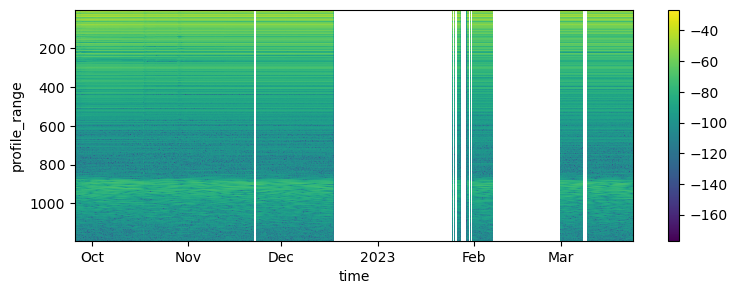

In [10]:
# Load data
ds_14 = reload_winter("A104")

# mask out periods without recording to prevent interpolation from filling those gaps
time_diffs = ds_14.time.diff(dim='time')
time_diffs = time_diffs.to_index().to_pytimedelta()
mask = time_diffs <= pd.Timedelta('30min')
mask_1 = xr.DataArray([True] + mask.tolist(), coords=[ds_14.time], dims=['time'])
mask_2 = xr.DataArray(mask.tolist() + [True], coords=[ds_14.time], dims=['time'])
masked_ds = ds_14.where(mask_1, other=np.nan).where(mask_2, other=np.nan)

profile = save_adjusted_profiles(masked_ds,200)

# Save
with open('A14_22W.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)

## A14 Summer 2023

Surface is around 6.31 m in apparent depth
Profile data size is 0.70489856 Gb


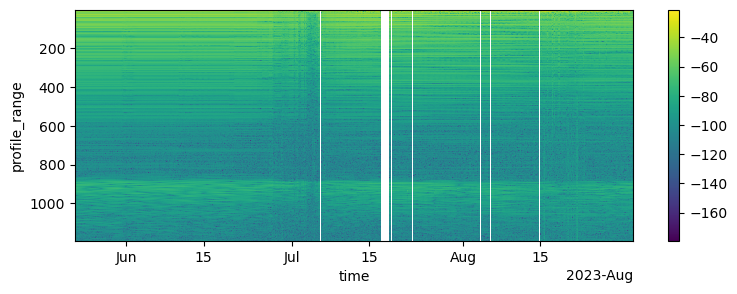

In [11]:
# Load data
ds_14 = reload_summer("A104")

profile = save_adjusted_profiles(ds_14,8000)

# Save
with open('A14_23S.pickle', 'wb') as handle:
    pickle.dump(profile, handle, protocol=pickle.HIGHEST_PROTOCOL)